<a href="https://colab.research.google.com/github/ifs21053-itdel/LostAndFound-ifs21053/blob/master/DE_Colorfullness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymoo
!pip install pymoode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=c2431d6371d42094f9bca78f320ae8012425fe991a556d7d621647251837d7c4
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: pymoo
    Fou

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize

# Algorithms
from pymoode.algorithms import NSDE

# Reference directions and test problems
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

# Survival operators
from pymoode.survival import RankAndCrowding, ConstrRankAndCrowding

# Termination
from pymoo.termination.default import DefaultSingleObjectiveTermination, DefaultMultiObjectiveTermination

# Performance
from pymoode.performance import SpacingIndicator

from pymoo.problems.functional import FunctionalProblem

In [ ]:
# Defining the colorfulness function (replacing rastrigin)
def colorfulness_func(x):
    r, g, b = x
    return np.sqrt((r - g) ** 2 + (g - b) ** 2 + (b - r) ** 2)

In [ ]:
# Functional problem for colorfulness
functional_colorfulness = FunctionalProblem(
    n_var=3,  # RGB components
    objs=colorfulness_func,
    xl=np.full(3, 0.0),  # Min value for RGB (0)
    xu=np.full(3, 255.0),  # Max value for RGB (255)
    constr_ieq=[]
)

In [ ]:
class ElementwiseColorfulness(ElementwiseProblem):

    def __init__(self):

        xl = np.full(3, 0.0)
        xu = np.full(3, 255.0)

        super().__init__(n_var=3, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = colorfulness_func(x)


In [ ]:
class Colorfulness(Problem):

    def __init__(self):

        xl = np.full(3, 0.0)
        xu = np.full(3, 255.0)

        super().__init__(n_var=3, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.sqrt((x[:, 0] - x[:, 1]) ** 2 + (x[:, 1] - x[:, 2]) ** 2 + (x[:, 2] - x[:, 0]) ** 2)


In [ ]:
nsde = NSDE(pop_size=50, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.5)

In [ ]:
NGEN = 100
SEED = 12

In [ ]:
termination_single = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=0.0,
    ftol=1e-8,
    period=20,
    n_max_gen=NGEN,
)

In [ ]:
colorfulness_problem = Colorfulness()

res_nsde_colorfulness = minimize(
    colorfulness_problem,
    nsde,
    termination=termination_single,
    seed=SEED,
    save_history=True,
    verbose=False
)

print(f"Optimal Colorfulness: {(res_nsde_colorfulness.F[0]):.4f}")
print(f"Optimal RGB Values: {(res_nsde_colorfulness.X)}")


Optimal Colorfulness: 0.0000
Optimal RGB Values: [254.99999995 254.99999997 254.99999994]


In [ ]:
# Creating a contour plot
r = np.linspace(0, 255, 100)
g = np.linspace(0, 255, 100)
b = np.linspace(0, 255, 100)
R, G = np.meshgrid(r, g)
B = np.vstack([b] * 100).T
X = np.vstack([R.flatten().reshape([1, -1]), G.flatten().reshape([1, -1]), B.flatten().reshape([1, -1])]).T
F = np.array([colorfulness_func(x) for x in X])
F = F.reshape([100, 100])

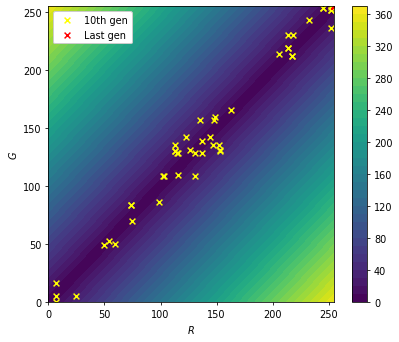

In [ ]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=70)

fig.patch.set_facecolor('white')

surf = ax.contourf(R, G, F, levels=40)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter(
    res_nsde_colorfulness.history[9].pop.get("X")[:, 0],
    res_nsde_colorfulness.history[9].pop.get("X")[:, 1],
    marker="x", color="yellow", label="10th gen",
)

ax.scatter(
    res_nsde_colorfulness.history[-1].pop.get("X")[:, 0],
    res_nsde_colorfulness.history[-1].pop.get("X")[:, 1],
    marker="x", color="red", label="Last gen",
)
ax.legend(framealpha=1.0)

ax.set_xlabel("$R$")
ax.set_ylabel("$G$")

plt.tight_layout()